> This notebook creates the ntlights preprocessed dataset from the EOG ntlights tiff files

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from shapely.geometry import Polygon
from matplotlib.colors import colorConverter
import geowrangler.raster_zonal_stats as rzs
from haversine import Direction, inverse_haversine

/home/jc_tm/project_repos/unicef-ai4d-poverty-mapping/env/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [3]:
# TODO: implement function as separate module when ready
# import povertymapping.viirs_data_proc as viirs

In [4]:
import sys

In [5]:
viirs_config = dict(
        save_path="../data/outputs/viirs_ph",
        repo_path="../data/SVII_PH_KH_MM_TL",
        viirs_tif_path="../data/outputs/viirs_ph/eog_PH_2017.tif",
        data_dir="ph",
        country="ph",
        viirs_folder="viirs_ph",
        hdx_folder="hdx_ph",
        dhs_folder="dhs_ph",
        dhs_geo_zip_folder="PHGE71FL",
        dhs_zip_folder="PHHR71DT",
        crs="4683",
        viirs_feature="avg_rad",
        boundary_file="phl_adminboundaries_candidate_adm3",
        year="2017",
        # sample=False,
        # random_sample=False,
        # no_samples=60,
        # random_seed=42,
        clust_rad=2000,
        plot_viirs_features=True,
        adm_level=3,
        use_pcode=True,
        shape_label='ADM3_PCODE',
        bins=6,
        show_legend=False,
    )

In [6]:
from pathlib import Path

In [7]:
# # uncomment and run the following to clear out the preprocessed files 
# !rm -rf {viirs_config['save_path']}
# !mkdir -p {viirs_config['save_path']}

In [8]:
cluster_coords_path = Path(viirs_config['save_path'])/'..'/viirs_config['dhs_folder']/f"{viirs_config['dhs_geo_zip_folder']}_cluster_coords.csv"
cluster_coords_path

PosixPath('../data/outputs/viirs_ph/../dhs_ph/PHGE71FL_cluster_coords.csv')

In [9]:
!cp {cluster_coords_path} {viirs_config['save_path']}/.

### Dev process_viirs_data()

In [10]:
viirs_tif_path = viirs_config['viirs_tif_path']

#### Open the tif file

In [11]:
with rio.open(viirs_tif_path) as dst:
    data = dst.read(1)
    print(data)

[[0.18399812 0.19208178 0.2039444  ... 0.15316088 0.1800387  0.17428316]
 [0.17762764 0.19316964 0.20672373 ... 0.17014433 0.18852577 0.182408  ]
 [0.18640055 0.19541879 0.18461716 ... 0.17492227 0.1974811  0.20390633]
 ...
 [0.24877347 0.25129357 0.280608   ... 0.18944512 0.19984274 0.23967312]
 [0.25689214 0.24893636 0.26223662 ... 0.2096378  0.22604159 0.25103217]
 [0.236746   0.22991171 0.2760854  ... 0.1685332  0.1776291  0.23493679]]


In [12]:
cluster_centroids_df = pd.read_csv(cluster_coords_path)

# Remove clusters with latitude == 0 
cluster_centroids_df = cluster_centroids_df[cluster_centroids_df.LATNUM > 0.0]

cluster_centroids_df.head(2)

,DHSID,DHSCC,DHSYEAR,DHSCLUST,CCFIPS,ADM1FIPS,ADM1FIPSNA,ADM1SALBNA,ADM1SALBCO,ADM1DHS,...,DHSREGCO,DHSREGNA,SOURCE,URBAN_RURA,LATNUM,LONGNUM,ALT_GPS,ALT_DEM,DATUM,geometry
0,PH201700000386,PH,2017.0,386.0,NaN,NaN,NaN,NaN,NaN,1.0,...,1.0,Ilocos,GPS,R,18.271892,120.564542,9999.0,17.0,WGS84,POINT (120.56454229 18.2718920623)
1,PH201700000387,PH,2017.0,387.0,NaN,NaN,NaN,NaN,NaN,1.0,...,1.0,Ilocos,GPS,U,18.202195,120.568506,9999.0,10.0,WGS84,POINT (120.568506409 18.2021947961)


In [13]:
cluster_centroids_gdf = gpd.GeoDataFrame(
    cluster_centroids_df,
    geometry=gpd.GeoSeries.from_wkt(cluster_centroids_df["geometry"], crs='epsg:4326')
)
cluster_centroids_gdf.head(2)

,DHSID,DHSCC,DHSYEAR,DHSCLUST,CCFIPS,ADM1FIPS,ADM1FIPSNA,ADM1SALBNA,ADM1SALBCO,ADM1DHS,...,DHSREGCO,DHSREGNA,SOURCE,URBAN_RURA,LATNUM,LONGNUM,ALT_GPS,ALT_DEM,DATUM,geometry
0,PH201700000386,PH,2017.0,386.0,NaN,NaN,NaN,NaN,NaN,1.0,...,1.0,Ilocos,GPS,R,18.271892,120.564542,9999.0,17.0,WGS84,POINT (120.56454 18.27189)
1,PH201700000387,PH,2017.0,387.0,NaN,NaN,NaN,NaN,NaN,1.0,...,1.0,Ilocos,GPS,U,18.202195,120.568506,9999.0,10.0,WGS84,POINT (120.56851 18.20219)


In [14]:
cluster_centroids_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot: >

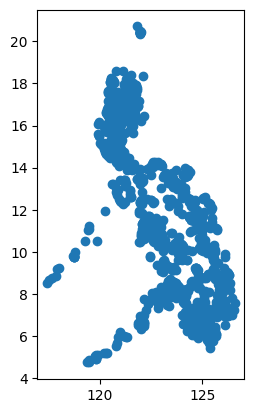

In [15]:
cluster_centroids_gdf.plot()

#### Function for creating the cluster bounding box

In [16]:
def create_polygon_bbox(centroid_lat, centroid_lon, distance_km):
    """Return bbox edge locations using haversine distance function
    The output is specified as (west, south, east, north)
    distance_km specifies the distance of each edge from the centroid
    """
    centroid = (centroid_lat, centroid_lon)
    top_left = inverse_haversine(
        inverse_haversine(centroid, distance_km, Direction.WEST),
        distance_km,
        Direction.NORTH,
    )
    bottom_right = inverse_haversine(
        inverse_haversine(centroid, distance_km, Direction.EAST),
        distance_km,
        Direction.SOUTH,
    )

    north, west = top_left
    south, east = bottom_right

    # check inequalities
    assert west < east
    assert south < north

    bbox_coord_list = [west, south, east, north]

    bbox = Polygon([[west, south], [east, south], [east, north], [west, north]])
    return bbox


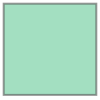

In [17]:
create_polygon_bbox(10,10,10)

In [18]:
def add_bbox_geom(cluster_centroids_gdf, distance_km, output_col='bbox'):
    """Add bbox geometry to dhs cluster data (i.e. 6th column)
    Args:
        cluster_centroid_gdf (gpd.GeoDataFrame): DHS data frame
        length (int): buffer radius in meters
    Returns:
        geopandas.GeoDataFrame
    """

    cluster_centroids_gdf = cluster_centroids_gdf.copy()

    centroids = list(
        zip(cluster_centroids_gdf["LATNUM"], cluster_centroids_gdf["LONGNUM"])
    )
    bbox_geometry = []
    print("Adding buffer geometry...")
    for centroid in tqdm(centroids):
        centroid_lat, centroid_lon = centroid
        bbox = create_polygon_bbox(centroid_lat, centroid_lon, distance_km)
        
        bbox_geometry.append(bbox)
    cluster_centroids_gdf[output_col] = bbox_geometry
    return cluster_centroids_gdf

In [19]:
cluster_bbox_gdf = add_bbox_geom(cluster_centroids_gdf, 2)
cluster_bbox_gdf['geometry'] = cluster_bbox_gdf['bbox']

Adding buffer geometry...


100%|██████████| 1214/1214 [00:00<00:00, 23675.48it/s]


<AxesSubplot: >

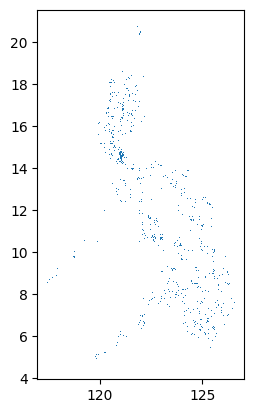

In [20]:
cluster_bbox_gdf.plot()

#### Raster zonal stats

In [21]:
cluster_zonal_stats_gdf = rzs.create_raster_zonal_stats(
    cluster_bbox_gdf,
    viirs_tif_path,
    aggregation=dict(
        # func=["min", "max", "mean", "median", "kurtosis", "var"],
        func=["min", "max", "mean", "median", "std"],
        column="avg_rad",
    ),
    extra_args=dict(band_num=1, nodata=-999),
)


In [22]:
cluster_zonal_stats_gdf.head()

,DHSID,DHSCC,DHSYEAR,DHSCLUST,CCFIPS,ADM1FIPS,ADM1FIPSNA,ADM1SALBNA,ADM1SALBCO,ADM1DHS,...,ALT_GPS,ALT_DEM,DATUM,geometry,bbox,avg_rad_min,avg_rad_max,avg_rad_mean,avg_rad_std,avg_rad_median
0,PH201700000386,PH,2017.0,386.0,NaN,NaN,NaN,NaN,NaN,1.0,...,9999.0,17.0,WGS84,"POLYGON ((120.54560 18.25390, 120.58348 18.253...",POLYGON ((120.54560084371413 18.25390472288926...,0.196119,1.391538,0.410263,0.260675,0.279534
1,PH201700000387,PH,2017.0,387.0,NaN,NaN,NaN,NaN,NaN,1.0,...,9999.0,10.0,WGS84,"POLYGON ((120.54957 18.18421, 120.58744 18.184...",POLYGON ((120.54957255328522 18.18420746049634...,0.389053,7.300686,2.008298,1.305749,1.690995
2,PH201700000388,PH,2017.0,388.0,NaN,NaN,NaN,NaN,NaN,1.0,...,9999.0,39.0,WGS84,"POLYGON ((120.67219 18.05593, 120.71003 18.055...",POLYGON ((120.67219287500379 18.05592686509549...,0.246468,0.511665,0.347220,0.056467,0.338678
3,PH201700000389,PH,2017.0,389.0,NaN,NaN,NaN,NaN,NaN,1.0,...,9999.0,13.0,WGS84,"POLYGON ((120.49128 18.04303, 120.52912 18.043...","POLYGON ((120.4912846023381 18.04302918609864,...",0.268062,6.462383,0.901461,1.259600,0.446334
4,PH201700000390,PH,2017.0,390.0,NaN,NaN,NaN,NaN,NaN,1.0,...,9999.0,126.0,WGS84,"POLYGON ((120.64414 18.13771, 120.68200 18.137...",POLYGON ((120.64414493860735 18.13770683763467...,0.319517,2.658939,0.610296,0.413121,0.499302


In [23]:
cluster_zonal_stats_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1214 entries, 0 to 1249
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   DHSID           1214 non-null   object  
 1   DHSCC           1214 non-null   object  
 2   DHSYEAR         1214 non-null   float64 
 3   DHSCLUST        1214 non-null   float64 
 4   CCFIPS          0 non-null      float64 
 5   ADM1FIPS        0 non-null      float64 
 6   ADM1FIPSNA      0 non-null      float64 
 7   ADM1SALBNA      0 non-null      float64 
 8   ADM1SALBCO      0 non-null      float64 
 9   ADM1DHS         1214 non-null   float64 
 10  ADM1NAME        1214 non-null   object  
 11  DHSREGCO        1214 non-null   float64 
 12  DHSREGNA        1214 non-null   object  
 13  SOURCE          1214 non-null   object  
 14  URBAN_RURA      1214 non-null   object  
 15  LATNUM          1214 non-null   float64 
 16  LONGNUM         1214 non-null   float64 
 17  ALT_GP

#### Prepare output files

In [24]:
output_gpkg_path = Path(viirs_config['save_path'])/'ph_2017_viirs_avg_rad_zonal_stats.gpkg'
output_csv_path = Path(viirs_config['save_path'])/'ph_2017_viirs_avg_rad_zonal_stats.csv'

In [25]:
## GPKG
output_gdf = cluster_zonal_stats_gdf.copy()
output_gdf['latitude'] = output_gdf['LATNUM']
output_gdf['longitude'] = output_gdf['LONGNUM']
usecols = [
    "DHSID",
    "longitude",
    "latitude",
    "avg_rad_min",
    "avg_rad_max",
    "avg_rad_mean",
    "avg_rad_std",
    "avg_rad_median",
    "geometry"
]

output_gdf = output_gdf[usecols]
output_gdf.to_file(output_gpkg_path, driver="GPKG")
output_gdf

/home/jc_tm/project_repos/unicef-ai4d-poverty-mapping/env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


,DHSID,longitude,latitude,avg_rad_min,avg_rad_max,avg_rad_mean,avg_rad_std,avg_rad_median,geometry
0,PH201700000386,120.564542,18.271892,0.196119,1.391538,0.410263,0.260675,0.279534,"POLYGON ((120.54560 18.25390, 120.58348 18.253..."
1,PH201700000387,120.568506,18.202195,0.389053,7.300686,2.008298,1.305749,1.690995,"POLYGON ((120.54957 18.18421, 120.58744 18.184..."
2,PH201700000388,120.691113,18.073914,0.246468,0.511665,0.347220,0.056467,0.338678,"POLYGON ((120.67219 18.05593, 120.71003 18.055..."
3,PH201700000389,120.510203,18.061017,0.268062,6.462383,0.901461,1.259600,0.446334,"POLYGON ((120.49128 18.04303, 120.52912 18.043..."
4,PH201700000390,120.663074,18.155694,0.319517,2.658939,0.610296,0.413121,0.499302,"POLYGON ((120.64414 18.13771, 120.68200 18.137..."
...,...,...,...,...,...,...,...,...,...
1245,PH201700000722,122.014801,12.480412,NaN,NaN,NaN,NaN,NaN,"POLYGON ((121.99638 12.46243, 122.03322 12.462..."
1246,PH201700000723,121.948492,12.332112,NaN,NaN,NaN,NaN,NaN,"POLYGON ((121.93008 12.31413, 121.96690 12.314..."
1247,PH201700000724,122.082036,12.825163,NaN,NaN,NaN,NaN,NaN,"POLYGON ((122.06359 12.80718, 122.10048 12.807..."
1248,PH201700000725,122.308962,12.506513,NaN,NaN,NaN,NaN,NaN,"POLYGON ((122.29054 12.48853, 122.32739 12.488..."


In [26]:
## CSV
usecols = [
    "DHSID",
    "longitude",
    "latitude",
    "avg_rad_min",
    "avg_rad_max",
    "avg_rad_mean",
    "avg_rad_std",
    "avg_rad_median",
]

output_df = output_gdf[usecols]
output_df.to_csv(output_csv_path)
output_df

,DHSID,longitude,latitude,avg_rad_min,avg_rad_max,avg_rad_mean,avg_rad_std,avg_rad_median
0,PH201700000386,120.564542,18.271892,0.196119,1.391538,0.410263,0.260675,0.279534
1,PH201700000387,120.568506,18.202195,0.389053,7.300686,2.008298,1.305749,1.690995
2,PH201700000388,120.691113,18.073914,0.246468,0.511665,0.347220,0.056467,0.338678
3,PH201700000389,120.510203,18.061017,0.268062,6.462383,0.901461,1.259600,0.446334
4,PH201700000390,120.663074,18.155694,0.319517,2.658939,0.610296,0.413121,0.499302
...,...,...,...,...,...,...,...,...
1245,PH201700000722,122.014801,12.480412,NaN,NaN,NaN,NaN,NaN
1246,PH201700000723,121.948492,12.332112,NaN,NaN,NaN,NaN,NaN
1247,PH201700000724,122.082036,12.825163,NaN,NaN,NaN,NaN,NaN
1248,PH201700000725,122.308962,12.506513,NaN,NaN,NaN,NaN,NaN


In [39]:
## Upload to gcs bucket
! gsutil cp {str(output_gpkg_path)} gs://poverty-mapping/outputs/viirs_ph/
! gsutil cp {str(output_csv_path)} gs://poverty-mapping/outputs/viirs_ph/



Updates are available for some Google Cloud CLI components.  To install them,
please run:
  $ gcloud components update

Copying file://../data/outputs/viirs_ph/ph_2017_viirs_avg_rad_zonal_stats.gpkg [Content-Type=application/octet-stream]...
Reauthentication required.0 KiB]                                                
Please enter your password:Caught CTRL-C (signal 2) - exiting


### EDA: Compare with Kahlil's output using QGIS

In [28]:
kahlil_cluster_zonal_stats_gdf = gpd.read_file(
    "../data/outputs/viirs_ph/rzs_dhs_viirs_ph_2017.gpkg"
)


In [29]:
kahlil_cluster_zonal_stats_gdf.head(3)

,DHSCLUST,Wealth Index,DHSID,DHSCC,DHSYEAR,CCFIPS,ADM1FIPS,ADM1FIPSNA,ADM1SALBNA,ADM1SALBCO,...,ALT_GPS,ALT_DEM,DATUM,rzs_mean,rzs_median,rzs_stdev,rzs_min,rzs_max,rzs_variance,geometry
0,1,-31881.608696,PH201700000001,PH,2017.0,NULL,NULL,NULL,NULL,NULL,...,9999.0,10.0,WGS84,0.265912,0.261700,0.029590,0.222937,0.375542,0.000876,"MULTIPOLYGON (((403606.834 739871.878, 403606...."
1,2,-2855.375000,PH201700000002,PH,2017.0,NULL,NULL,NULL,NULL,NULL,...,9999.0,5.0,WGS84,0.981981,0.346526,1.325483,0.224869,6.881082,1.756904,"MULTIPOLYGON (((406060.603 738497.001, 406060...."
2,3,-57647.047619,PH201700000003,PH,2017.0,NULL,NULL,NULL,NULL,NULL,...,9999.0,47.0,WGS84,0.328983,0.288842,0.115563,0.224655,0.865518,0.013355,"MULTIPOLYGON (((411300.477 734017.843, 411300...."


In [30]:
kahlil_cluster_zonal_stats_gdf[kahlil_cluster_zonal_stats_gdf['DHSID'] == 'PH201700000020']

,DHSCLUST,Wealth Index,DHSID,DHSCC,DHSYEAR,CCFIPS,ADM1FIPS,ADM1FIPSNA,ADM1SALBNA,ADM1SALBCO,...,ALT_GPS,ALT_DEM,DATUM,rzs_mean,rzs_median,rzs_stdev,rzs_min,rzs_max,rzs_variance,geometry
19,20,-104656.428571,PH201700000020,PH,2017.0,NULL,NULL,NULL,NULL,NULL,...,9999.0,9999.0,WGS84,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((-7272487.381 19997929.886, -72..."


In [31]:
kahlil_cluster_zonal_stats_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1249 entries, 0 to 1248
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   DHSCLUST      1249 non-null   int64   
 1   Wealth Index  1249 non-null   float64 
 2   DHSID         1249 non-null   object  
 3   DHSCC         1249 non-null   object  
 4   DHSYEAR       1249 non-null   float64 
 5   CCFIPS        1249 non-null   object  
 6   ADM1FIPS      1249 non-null   object  
 7   ADM1FIPSNA    1249 non-null   object  
 8   ADM1SALBNA    1249 non-null   object  
 9   ADM1SALBCO    1249 non-null   object  
 10  ADM1DHS       1249 non-null   float64 
 11  ADM1NAME      1249 non-null   object  
 12  DHSREGCO      1249 non-null   float64 
 13  DHSREGNA      1249 non-null   object  
 14  SOURCE        1249 non-null   object  
 15  URBAN_RURA    1249 non-null   object  
 16  LATNUM        1249 non-null   float64 
 17  LONGNUM       1249 non-null   float64 
 18  

In [32]:
usecols_left = [
    "DHSID",
    "avg_rad_min",
    "avg_rad_max",
    "avg_rad_mean",
    "avg_rad_std",
    "avg_rad_median",
    "geometry"
]
cluster_zonal_stats_gdf = cluster_zonal_stats_gdf[usecols_left]
cluster_zonal_stats_gdf.head() 


,DHSID,avg_rad_min,avg_rad_max,avg_rad_mean,avg_rad_std,avg_rad_median,geometry
0,PH201700000386,0.196119,1.391538,0.410263,0.260675,0.279534,"POLYGON ((120.54560 18.25390, 120.58348 18.253..."
1,PH201700000387,0.389053,7.300686,2.008298,1.305749,1.690995,"POLYGON ((120.54957 18.18421, 120.58744 18.184..."
2,PH201700000388,0.246468,0.511665,0.347220,0.056467,0.338678,"POLYGON ((120.67219 18.05593, 120.71003 18.055..."
3,PH201700000389,0.268062,6.462383,0.901461,1.259600,0.446334,"POLYGON ((120.49128 18.04303, 120.52912 18.043..."
4,PH201700000390,0.319517,2.658939,0.610296,0.413121,0.499302,"POLYGON ((120.64414 18.13771, 120.68200 18.137..."


In [33]:
cluster_zonal_stats_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1214 entries, 0 to 1249
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   DHSID           1214 non-null   object  
 1   avg_rad_min     1178 non-null   float64 
 2   avg_rad_max     1178 non-null   float64 
 3   avg_rad_mean    1178 non-null   float64 
 4   avg_rad_std     1178 non-null   float64 
 5   avg_rad_median  1178 non-null   float64 
 6   geometry        1214 non-null   geometry
dtypes: float64(5), geometry(1), object(1)
memory usage: 108.2+ KB


In [34]:
usecols_right = [
    "DHSID",
    "rzs_min",
    "rzs_max",
    "rzs_mean",
    "rzs_stdev",
    "rzs_median",
]
kahlil_cluster_zonal_stats_gdf = kahlil_cluster_zonal_stats_gdf[usecols_right]
kahlil_cluster_zonal_stats_gdf.head()

,DHSID,rzs_min,rzs_max,rzs_mean,rzs_stdev,rzs_median
0,PH201700000001,0.222937,0.375542,0.265912,0.029590,0.261700
1,PH201700000002,0.224869,6.881082,0.981981,1.325483,0.346526
2,PH201700000003,0.224655,0.865518,0.328983,0.115563,0.288842
3,PH201700000004,0.184109,0.341882,0.230732,0.022960,0.226286
4,PH201700000005,NaN,NaN,NaN,NaN,NaN


In [35]:
kahlil_cluster_zonal_stats_gdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1249 entries, 0 to 1248
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DHSID       1249 non-null   object 
 1   rzs_min     1213 non-null   float64
 2   rzs_max     1213 non-null   float64
 3   rzs_mean    1213 non-null   float64
 4   rzs_stdev   1213 non-null   float64
 5   rzs_median  1213 non-null   float64
dtypes: float64(5), object(1)
memory usage: 58.7+ KB


In [36]:
# Merge
cluster_zonal_stats_gdf['DHSID'] = cluster_zonal_stats_gdf['DHSID'].astype(str)
kahlil_cluster_zonal_stats_gdf['DHSID'] = kahlil_cluster_zonal_stats_gdf['DHSID'].astype(str)
combined_zonal_stats = cluster_zonal_stats_gdf.merge(kahlil_cluster_zonal_stats_gdf, on=["DHSID"], how="outer")

combined_zonal_stats.head()


,DHSID,avg_rad_min,avg_rad_max,avg_rad_mean,avg_rad_std,avg_rad_median,geometry,rzs_min,rzs_max,rzs_mean,rzs_stdev,rzs_median
0,PH201700000386,0.196119,1.391538,0.410263,0.260675,0.279534,"POLYGON ((120.54560 18.25390, 120.58348 18.253...",0.196119,1.391538,0.405251,0.259855,0.275098
1,PH201700000387,0.389053,7.300686,2.008298,1.305749,1.690995,"POLYGON ((120.54957 18.18421, 120.58744 18.184...",0.389053,8.644136,2.131632,1.524006,1.712358
2,PH201700000388,0.246468,0.511665,0.347220,0.056467,0.338678,"POLYGON ((120.67219 18.05593, 120.71003 18.055...",0.246468,0.511665,0.347220,0.056467,0.338678
3,PH201700000389,0.268062,6.462383,0.901461,1.259600,0.446334,"POLYGON ((120.49128 18.04303, 120.52912 18.043...",0.268062,6.462383,0.872115,1.223619,0.415388
4,PH201700000390,0.319517,2.658939,0.610296,0.413121,0.499302,"POLYGON ((120.64414 18.13771, 120.68200 18.137...",0.318214,2.658939,0.603239,0.409725,0.483755


In [37]:
zonal_stat_pairs = list(zip(usecols_left,usecols_right))[1:]
zonal_stat_pairs

[('avg_rad_min', 'rzs_min'),
 ('avg_rad_max', 'rzs_max'),
 ('avg_rad_mean', 'rzs_mean'),
 ('avg_rad_std', 'rzs_stdev'),
 ('avg_rad_median', 'rzs_median')]

['DHSID', 'avg_rad_min', 'rzs_min']


,DHSID,avg_rad_min,rzs_min,abs_diff,avg,pct_diff
927,PH201700000326,0.165500,20.654139,20.488639,10.409819,196.820315
926,PH201700000325,0.223607,20.654139,20.430531,10.438873,195.715872
936,PH201700000335,0.167861,14.963068,14.795207,7.565465,195.562430
934,PH201700000333,0.176862,15.516428,15.339566,7.846645,195.492042
822,PH201700001250,15.841383,0.196275,15.645108,8.018829,195.104650
...,...,...,...,...,...,...
9,PH201700000395,0.280226,0.280226,0.000000,0.280226,0.000000
10,PH201700000396,0.161995,0.161995,0.000000,0.161995,0.000000
11,PH201700000397,0.346775,0.346775,0.000000,0.346775,0.000000
15,PH201700000401,0.409413,0.409413,0.000000,0.409413,0.000000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1177 entries, 0 to 1177
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DHSID        1177 non-null   object 
 1   avg_rad_min  1177 non-null   float64
 2   rzs_min      1177 non-null   float64
 3   abs_diff     1177 non-null   float64
 4   avg          1177 non-null   float64
 5   pct_diff     1177 non-null   float64
dtypes: float64(5), object(1)
memory usage: 64.4+ KB


None

,DHSID,avg_rad_min,rzs_min,abs_diff,avg,pct_diff
0,PH201700000386,0.196119,0.196119,0.0,0.196119,0.0
1,PH201700000387,0.389053,0.389053,0.0,0.389053,0.0
2,PH201700000388,0.246468,0.246468,0.0,0.246468,0.0
3,PH201700000389,0.268062,0.268062,0.0,0.268062,0.0
5,PH201700000391,0.193072,0.193072,0.0,0.193072,0.0
6,PH201700000392,0.291583,0.291583,0.0,0.291583,0.0
7,PH201700000393,0.196885,0.196885,0.0,0.196885,0.0
8,PH201700000394,0.246468,0.246468,0.0,0.246468,0.0
9,PH201700000395,0.280226,0.280226,0.0,0.280226,0.0
10,PH201700000396,0.161995,0.161995,0.0,0.161995,0.0


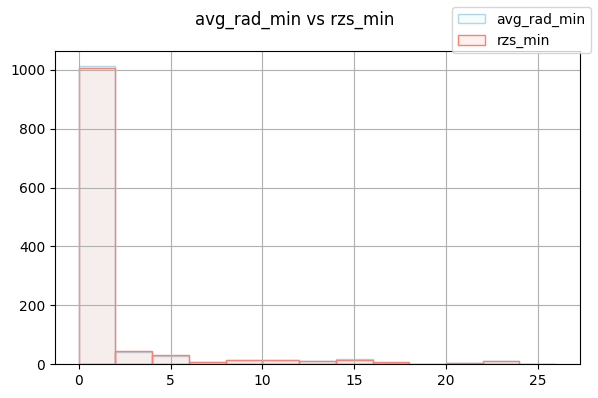

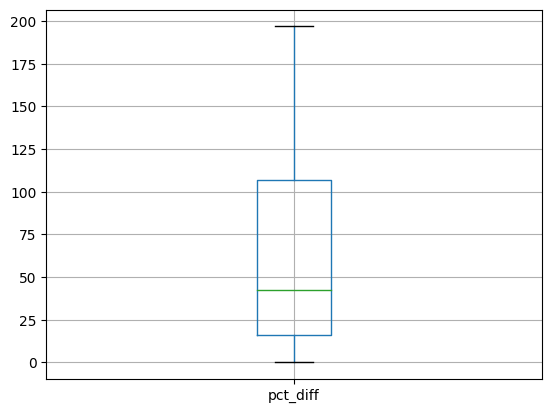

['DHSID', 'avg_rad_max', 'rzs_max']


,DHSID,avg_rad_max,rzs_max,abs_diff,avg,pct_diff
934,PH201700000333,0.235426,104.334267,104.098841,52.284846,199.099449
936,PH201700000335,0.242813,80.001572,79.758759,40.122192,198.789632
937,PH201700000336,0.256106,80.001572,79.745466,40.128839,198.723581
935,PH201700000334,0.282405,80.001572,79.719167,40.141988,198.592972
933,PH201700000332,0.283060,80.001572,79.718512,40.142316,198.589719
...,...,...,...,...,...,...
15,PH201700000401,7.289020,7.289020,0.000000,7.289020,0.000000
16,PH201700000402,0.593529,0.593529,0.000000,0.593529,0.000000
194,PH201700000584,3.201763,3.201763,0.000000,3.201763,0.000000
152,PH201700000542,28.368755,28.368755,0.000000,28.368755,0.000000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1177 entries, 0 to 1177
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DHSID        1177 non-null   object 
 1   avg_rad_max  1177 non-null   float64
 2   rzs_max      1177 non-null   float64
 3   abs_diff     1177 non-null   float64
 4   avg          1177 non-null   float64
 5   pct_diff     1177 non-null   float64
dtypes: float64(5), object(1)
memory usage: 64.4+ KB


None

,DHSID,avg_rad_max,rzs_max,abs_diff,avg,pct_diff
0,PH201700000386,1.391538,1.391538,0.0,1.391538,0.0
2,PH201700000388,0.511665,0.511665,0.0,0.511665,0.0
3,PH201700000389,6.462383,6.462383,0.0,6.462383,0.0
4,PH201700000390,2.658939,2.658939,0.0,2.658939,0.0
5,PH201700000391,0.368501,0.368501,0.0,0.368501,0.0
6,PH201700000392,14.821279,14.821279,0.0,14.821279,0.0
7,PH201700000393,0.592741,0.592741,0.0,0.592741,0.0
8,PH201700000394,0.511665,0.511665,0.0,0.511665,0.0
9,PH201700000395,4.128791,4.128791,0.0,4.128791,0.0
10,PH201700000396,0.797952,0.797952,0.0,0.797952,0.0


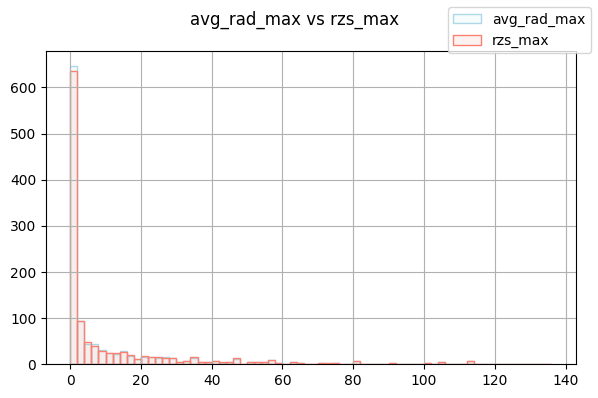

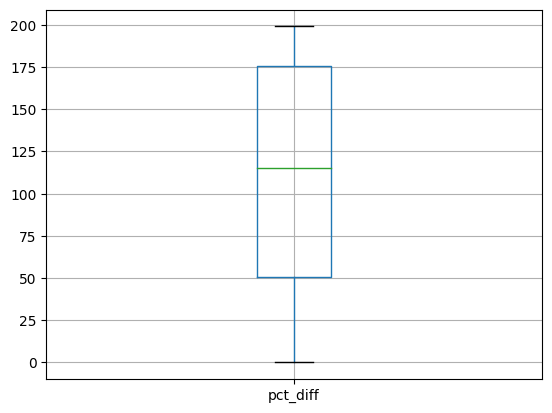

['DHSID', 'avg_rad_mean', 'rzs_mean']


,DHSID,avg_rad_mean,rzs_mean,abs_diff,avg,pct_diff
934,PH201700000333,0.208300,37.934890,3.772659e+01,19.071595,1.978156e+02
931,PH201700000330,0.239898,39.595623,3.935573e+01,19.917761,1.975911e+02
822,PH201700001250,37.225815,0.241771,3.698404e+01,18.733793,1.974189e+02
927,PH201700000326,0.203769,31.056626,3.085286e+01,15.630197,1.973926e+02
936,PH201700000335,0.207031,29.402678,2.919565e+01,14.804854,1.972032e+02
...,...,...,...,...,...,...
2,PH201700000388,0.347220,0.347220,6.806703e-09,0.347220,1.960341e-06
6,PH201700000392,2.197849,2.197849,3.973643e-08,2.197849,1.807969e-06
13,PH201700000399,0.289558,0.289558,4.139211e-09,0.289558,1.429492e-06
16,PH201700000402,0.368128,0.368128,4.415159e-09,0.368128,1.199355e-06


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1177 entries, 0 to 1177
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DHSID         1177 non-null   object 
 1   avg_rad_mean  1177 non-null   float64
 2   rzs_mean      1177 non-null   float64
 3   abs_diff      1177 non-null   float64
 4   avg           1177 non-null   float64
 5   pct_diff      1177 non-null   float64
dtypes: float64(5), object(1)
memory usage: 64.4+ KB


None

,DHSID,avg_rad_mean,rzs_mean,abs_diff,avg,pct_diff


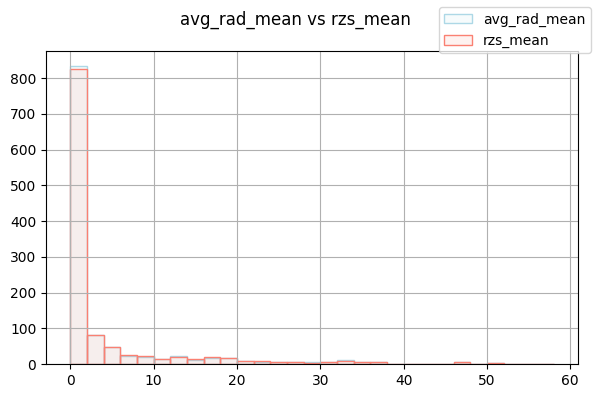

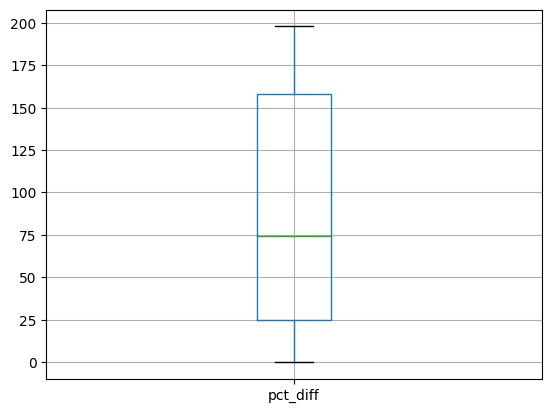

['DHSID', 'avg_rad_std', 'rzs_stdev']


,DHSID,avg_rad_std,rzs_stdev,abs_diff,avg,pct_diff
934,PH201700000333,0.010745,21.045409,2.103466e+01,10.528077,1.997959e+02
822,PH201700001250,16.332844,0.018257,1.631459e+01,8.175550,1.995534e+02
937,PH201700000336,0.014798,12.150881,1.213608e+01,6.082840,1.995134e+02
706,PH201700001135,13.676804,0.018170,1.365863e+01,6.847487,1.994693e+02
935,PH201700000334,0.017697,12.977068,1.295937e+01,6.497382,1.994553e+02
...,...,...,...,...,...,...
11,PH201700000397,2.692361,2.692361,6.661338e-15,2.692361,2.474162e-13
13,PH201700000399,0.060621,0.060621,1.457168e-16,0.060621,2.403751e-13
16,PH201700000402,0.072370,0.072370,1.526557e-16,0.072370,2.109373e-13
6,PH201700000392,2.795605,2.795605,0.000000e+00,2.795605,0.000000e+00


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1177 entries, 0 to 1177
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DHSID        1177 non-null   object 
 1   avg_rad_std  1177 non-null   float64
 2   rzs_stdev    1177 non-null   float64
 3   abs_diff     1177 non-null   float64
 4   avg          1177 non-null   float64
 5   pct_diff     1177 non-null   float64
dtypes: float64(5), object(1)
memory usage: 64.4+ KB


None

,DHSID,avg_rad_std,rzs_stdev,abs_diff,avg,pct_diff
6,PH201700000392,2.795605,2.795605,0.0,2.795605,0.0
9,PH201700000395,0.859464,0.859464,0.0,0.859464,0.0


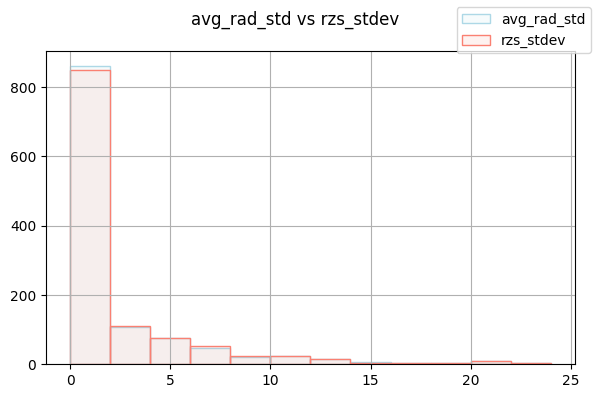

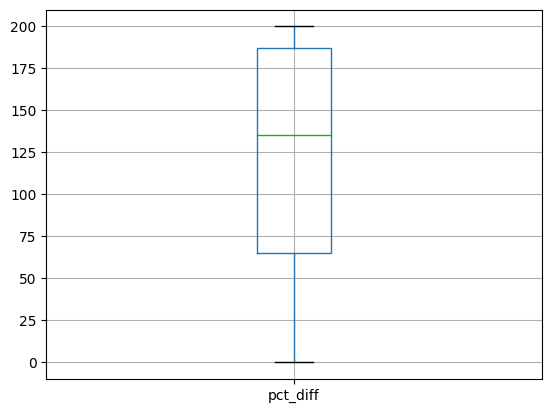

['DHSID', 'avg_rad_median', 'rzs_median']


,DHSID,avg_rad_median,rzs_median,abs_diff,avg,pct_diff
934,PH201700000333,0.208723,31.935932,31.727209,16.072328,197.402705
425,PH201700000378,37.072456,0.242767,36.829689,18.657612,197.397661
931,PH201700000330,0.225248,33.502945,33.277697,16.864096,197.328668
929,PH201700000328,0.235627,35.018345,34.782718,17.626986,197.326523
927,PH201700000326,0.199338,29.279701,29.080363,14.739520,197.295185
...,...,...,...,...,...,...
9,PH201700000395,1.121043,1.121043,0.000000,1.121043,0.000000
5,PH201700000391,0.226768,0.226768,0.000000,0.226768,0.000000
2,PH201700000388,0.338678,0.338678,0.000000,0.338678,0.000000
16,PH201700000402,0.372673,0.372673,0.000000,0.372673,0.000000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1177 entries, 0 to 1177
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DHSID           1177 non-null   object 
 1   avg_rad_median  1177 non-null   float64
 2   rzs_median      1177 non-null   float64
 3   abs_diff        1177 non-null   float64
 4   avg             1177 non-null   float64
 5   pct_diff        1177 non-null   float64
dtypes: float64(5), object(1)
memory usage: 64.4+ KB


None

,DHSID,avg_rad_median,rzs_median,abs_diff,avg,pct_diff
2,PH201700000388,0.338678,0.338678,0.0,0.338678,0.0
5,PH201700000391,0.226768,0.226768,0.0,0.226768,0.0
8,PH201700000394,0.332365,0.332365,0.0,0.332365,0.0
9,PH201700000395,1.121043,1.121043,0.0,1.121043,0.0
11,PH201700000397,0.919298,0.919298,0.0,0.919298,0.0
16,PH201700000402,0.372673,0.372673,0.0,0.372673,0.0


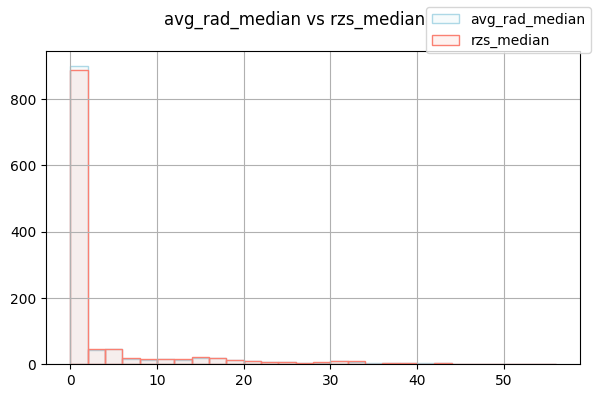

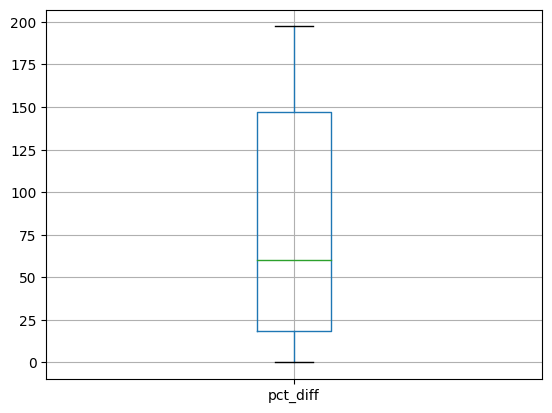

In [38]:
for pair in zonal_stat_pairs:
    usecols = ["DHSID"] + list(pair)
    print(usecols)

    df = combined_zonal_stats[usecols].dropna(how="any").copy()
    df["abs_diff"] = np.abs(df[pair[0]].sub(df[pair[1]]))
    df["avg"] = (df[pair[0]] + df[pair[1]]) / 2
    df["pct_diff"] = (df["abs_diff"] / df['avg']) * 100
    display(df.sort_values(by="pct_diff", ascending=False))
    display(df.info())
    display(df[df['abs_diff']==0])

    fig, ax = plt.subplots(figsize=(6, 4))
    colors = ["lightblue", "salmon"]
    for i, stat in enumerate(pair):
        facecolor = colorConverter.to_rgba(colors[i], alpha=0.1)
        edgecolor = colors[i]
        df[stat].hist(
            ax=ax,
            label=stat,
            facecolor=facecolor,
            edgecolor=edgecolor,
            bins=np.arange(0, np.max(df[stat]), 2),
        )
    fig.legend()
    fig.suptitle(f"{pair[0]} vs {pair[1]}")
    plt.tight_layout()
    plt.show()

    df.dropna(how="any").boxplot("pct_diff")
    plt.show()
